In [1]:
%matplotlib inline

In [2]:
import theano

In [3]:
from theano import function, config, shared, tensor
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[Elemwise{exp,no_inplace}(<TensorType(float64, vector)>)]
Looping 1000 times took 18.596000 seconds
Result is [ 1.23178032  1.61879341  1.52278065 ...,  2.20771815  2.29967753
  1.62323285]
Used the cpu


In [4]:
import os
import sys
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import keras
#from keras import backend as K
from keras.callbacks import LearningRateScheduler
from keras.layers import Input
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using Theano backend.


In [5]:
cwd = os.getcwd()
cwd

'C:\\Users\\Chris\\Documents\\kaggle\\personalized medicine\\misc-master\\misc-master'

In [6]:
%ls

 Volume in drive C has no label.
 Volume Serial Number is AC1A-A21A

 Directory of C:\Users\Chris\Documents\kaggle\personalized medicine\misc-master\misc-master

09/30/2017  09:51 PM    <DIR>          .
09/30/2017  09:51 PM    <DIR>          ..
09/30/2017  08:39 PM    <DIR>          .ipynb_checkpoints
09/30/2017  08:37 PM            65,152 full_prec_med_text_vars_API-20170929.ipynb
09/30/2017  08:27 PM    <DIR>          out
09/30/2017  09:51 PM            57,819 prec_med_resnet.ipynb
09/30/2017  08:25 PM                 6 README.md
09/30/2017  08:25 PM            19,675 stage2_5eps_labels.csv
09/30/2017  08:25 PM           144,574 stage2_preds.csv
09/30/2017  08:25 PM           152,976 stage2_preds_4epochs.csv
09/30/2017  08:25 PM           153,967 stage2_preds_5epochs.csv
               7 File(s)        594,169 bytes
               4 Dir(s)  422,624,555,008 bytes free


In [7]:
INPUT_DIR = 'C:\\Users\\Chris\\Documents\\kaggle\\personalized medicine\\input\\'

GLOVE_DIR = 'C:\\Users\\Chris\\Documents\\kaggle\\personalized medicine\\glove.6B\\'

In [8]:
test_text = pd.read_csv(os.path.join(INPUT_DIR, 'test_text'), sep = '\n')
test_text.head()

,"ID,Text"
0,0||2. This mutation resulted in a myeloprolife...
1,1|| Abstract The Large Tumor Suppressor 1 (LAT...
2,2||Vascular endothelial growth factor receptor...
3,3||Inflammatory myofibroblastic tumor (IMT) is...
4,4|| Abstract Retinoblastoma is a pediatric ret...


In [9]:
test_text = test_text['ID,Text'].str.split('\|\|', expand=True, n=1)
test_text = test_text.rename(columns={0: "ID", 1: "Text"})
test_text['ID'] = test_text['ID'].astype(int)

In [10]:
test_text.tail()
#test_text.shape
type(test_text['ID'].values[0])

numpy.int32

In [11]:
test_variants = pd.read_csv(os.path.join(INPUT_DIR, 'test_variants'))
#train_vars = train_vars.sort_index(axis=1)
test_variants['Group'] = 'test'

In [12]:
test_variants.tail()
#test_variants.shape

,ID,Gene,Variation,Group
5663,5663,SLC46A1,R113S,test
5664,5664,FOXC1,L130F,test
5665,5665,GSS,R267W,test
5666,5666,CTSK,G79E,test
5667,5667,DFNB59,T54I,test


In [13]:
stage1_solutions = pd.read_csv(os.path.join(INPUT_DIR, 'stage1_solution_filtered.csv'))
stage1_solutions.head()
#stage1_preclasses = stage1_solutions.drop('ID', axis=1).as_matrix()
#stage1_preclasses
# = pd.DataFrame(stage1_preclasses)
#stage1_preclasses_df.head()

,ID,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,12,1,0,0,0,0,0,0,0,0
1,19,0,1,0,0,0,0,0,0,0
2,21,0,1,0,0,0,0,0,0,0
3,55,0,0,0,1,0,0,0,0,0
4,64,0,0,0,1,0,0,0,0,0


In [14]:
hist = stage1_solutions.drop('ID', axis=1)
hist = np.argmax(hist.values, axis=1)
#test_labels = pd.DataFrame(test_labels, columns = ['Class'])
#test_labels['Class'].unique()
#test_labels = test_labels.append(pd.DataFrame([2,7,8], columns = ['Class']))
#test_labels.head()
hist

array([0, 1, 1, 3, 3, 3, 8, 6, 6, 6, 1, 0, 3, 0, 0, 0, 1, 2, 1, 6, 1, 0, 6,
       6, 2, 6, 8, 6, 0, 3, 0, 5, 3, 8, 5, 3, 0, 4, 1, 0, 2, 1, 6, 6, 4, 6,
       3, 5, 3, 0, 0, 3, 6, 0, 5, 6, 0, 0, 6, 1, 6, 1, 0, 6, 3, 8, 6, 3, 3,
       0, 3, 4, 0, 0, 0, 3, 1, 1, 0, 6, 0, 4, 5, 6, 5, 5, 0, 6, 4, 1, 0, 3,
       6, 6, 3, 0, 0, 3, 6, 0, 0, 1, 2, 6, 1, 1, 6, 3, 0, 3, 3, 6, 3, 6, 6,
       6, 5, 2, 6, 6, 3, 3, 3, 1, 3, 0, 3, 0, 3, 0, 1, 3, 6, 6, 3, 6, 6, 6,
       3, 0, 1, 6, 3, 0, 0, 6, 1, 6, 6, 6, 1, 1, 0, 3, 0, 0, 6, 6, 0, 4, 3,
       3, 6, 1, 0, 1, 3, 5, 3, 6, 0, 0, 0, 0, 6, 6, 3, 4, 3, 0, 3, 1, 5, 6,
       3, 4, 6, 2, 0, 6, 5, 1, 0, 7, 6, 6, 4, 6, 4, 4, 0, 0, 0, 6, 6, 1, 0,
       0, 6, 0, 1, 0, 3, 8, 0, 1, 6, 6, 0, 1, 3, 0, 3, 6, 6, 0, 3, 7, 3, 4,
       3, 3, 4, 0, 3, 0, 1, 6, 1, 3, 0, 5, 5, 4, 6, 6, 5, 1, 6, 8, 0, 0, 1,
       5, 6, 6, 6, 0, 0, 0, 3, 4, 6, 6, 6, 1, 4, 6, 0, 5, 6, 0, 4, 4, 5, 6,
       1, 0, 1, 3, 1, 6, 6, 3, 0, 4, 6, 1, 4, 5, 3, 4, 6, 4, 6, 6, 0, 6, 6,
       4, 6,

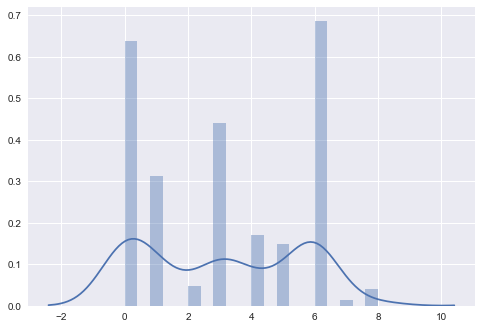

In [15]:
sns.distplot(hist, bins=20)

In [16]:
training_text = pd.read_csv(os.path.join(INPUT_DIR, 'training_text'), sep = '\n')
training_text.head()

,"ID,Text"
0,0||Cyclin-dependent kinases (CDKs) regulate a ...
1,1|| Abstract Background Non-small cell lung c...
2,2|| Abstract Background Non-small cell lung c...
3,3||Recent evidence has demonstrated that acqui...
4,4||Oncogenic mutations in the monomeric Casita...


In [17]:
training_text = training_text['ID,Text'].str.split('\|\|', expand=True, n=1)
training_text = training_text.rename(columns={0: "ID", 1: "Text"})
training_text['ID'] = training_text['ID'].astype(int)

In [18]:
training_text.head()
#training_text.shape
type(training_text['ID'].values[0])

numpy.int32

In [19]:
training_variants = pd.read_csv(os.path.join(INPUT_DIR, 'training_variants'))
training_variants['Group'] = 'train'

In [20]:
training_variants.head()
#training_variants.shape

,ID,Gene,Variation,Class,Group
0,0,FAM58A,Truncating Mutations,1,train
1,1,CBL,W802*,2,train
2,2,CBL,Q249E,2,train
3,3,CBL,N454D,3,train
4,4,CBL,L399V,4,train


In [21]:
#import stage2 here to use variants for one hot encoding
stage2_text = pd.read_csv(os.path.join(INPUT_DIR, 'stage2_test_text.csv'), sep = '\n')
stage2_text.head()

,"ID,Text"
0,1||The incidence of breast cancer is increasin...
1,2||An unselected series of 310 colorectal carc...
2,3||Mycosis fungoides and Sézary syndrome are p...
3,4|| Regulated progression through the cell cyc...
4,5||Pilocytic astrocytoma (PA) is emerging as a...


In [22]:
stage2_text = stage2_text['ID,Text'].str.split('\|\|', expand=True, n=1)
stage2_text = stage2_text.rename(columns={0: "ID", 1: "Text"})
stage2_text['ID'] = stage2_text['ID'].astype(int)

In [23]:
stage2_text.tail()
stage2_text.shape
type(stage2_text['ID'].values[0])

numpy.int32

In [24]:
stage2_variants = pd.read_csv(os.path.join(INPUT_DIR, 'stage2_test_variants.csv'))
stage2_variants['Group'] = 'stage2'

In [25]:
stage2_variants.tail()
#test_variants.shape

,ID,Gene,Variation,Group
981,982,TP63,S580P,stage2
982,983,SCN4A,R672G,stage2
983,984,BRAF,N581H,stage2
984,985,TSHR,S281N,stage2
985,986,ASS1,S180N,stage2


In [26]:
variants=pd.concat([training_variants.drop('Class', axis=1), test_variants, stage2_variants])
variants.head()

,ID,Gene,Variation,Group
0,0,FAM58A,Truncating Mutations,train
1,1,CBL,W802*,train
2,2,CBL,Q249E,train
3,3,CBL,N454D,train
4,4,CBL,L399V,train


In [27]:
variants.shape

(9975, 4)

In [28]:
variant_dummies = pd.get_dummies(variants, columns=['Gene', 'Variation'], drop_first=True)
variant_dummies.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
test_variants_dummies = variant_dummies[variant_dummies['Group'] == 'test']
test_variants_dummies.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
test_no_labels = test_variants_dummies.merge(test_text, left_on='ID', right_on='ID')
test_union = pd.merge(test_no_labels, stage1_solutions, on='ID', how='left')
test_union.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Text,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,0,test,0,0,0,0,0,0,0,0,...,2. This mutation resulted in a myeloproliferat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,test,0,0,0,0,0,0,0,0,...,Abstract The Large Tumor Suppressor 1 (LATS1)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,test,0,0,0,0,0,0,0,0,...,Vascular endothelial growth factor receptor (V...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,test,0,0,0,0,0,0,0,0,...,Inflammatory myofibroblastic tumor (IMT) is a ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,test,0,0,0,0,0,0,0,0,...,Abstract Retinoblastoma is a pediatric retina...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
test_full = test_union[test_union.isnull().any(axis=1)]
test_full = test_full.reset_index(drop=True)
test_full = test_full.iloc[:, :test_full.shape[1]-9]
test_full.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF,Text
0,0,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2. This mutation resulted in a myeloproliferat...
1,1,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Vascular endothelial growth factor receptor (V...
3,3,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Abstract Retinoblastoma is a pediatric retina...


In [32]:
test_full.isnull().values.any()

False

In [33]:
test_full.shape

(5300, 10268)

In [34]:
test_validations = test_union.dropna().copy()
test_validations = test_validations.reset_index(drop=True)
test_validations.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Text,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,12,test,0,0,0,0,0,0,0,0,...,TET proteins oxidize 5-methylcytosine (5mC) on...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19,test,0,0,0,0,0,0,0,0,...,Genes encoding components of the PI3K-Akt-mTOR...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21,test,0,0,0,0,0,0,0,0,...,Myeloproliferative disorders (MPD) constitute ...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55,test,0,0,0,0,0,0,0,0,...,"In the largest E3 ligase subfamily, Cul3 binds...",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,64,test,0,0,0,0,0,0,0,0,...,Keap1 is the substrate recognition module of a...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [35]:
test_validations.shape

(368, 10277)

In [36]:
training_variants_dummies = variant_dummies[variant_dummies['Group'] == 'train']
training_variants_dummies.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
training_dummies_text = training_variants_dummies.merge(training_text, left_on='ID', right_on='ID')
training_dummies_text.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF,Text
0,0,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Abstract Background Non-small cell lung canc...
2,2,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Abstract Background Non-small cell lung canc...
3,3,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Recent evidence has demonstrated that acquired...
4,4,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Oncogenic mutations in the monomeric Casitas B...


In [38]:
training_variants['Class'] = training_variants['Class']-1
training_variants.head()

,ID,Gene,Variation,Class,Group
0,0,FAM58A,Truncating Mutations,0,train
1,1,CBL,W802*,1,train
2,2,CBL,Q249E,1,train
3,3,CBL,N454D,2,train
4,4,CBL,L399V,3,train


In [39]:
training_one_hot = keras.utils.to_categorical(training_variants['Class'])
training_one_hot

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [40]:
training_one_hot_colnames = pd.DataFrame(training_one_hot, columns=['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8'])
training_one_hot_colnames.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [41]:
training_one_hot_colnames.shape

(3321, 9)

In [42]:
training_full = pd.concat([training_dummies_text, training_one_hot_colnames], axis=1)
training_full.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Text,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,0,train,0,0,0,0,0,0,0,0,...,Cyclin-dependent kinases (CDKs) regulate a var...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,train,0,0,0,0,0,0,0,0,...,Abstract Background Non-small cell lung canc...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,train,0,0,0,0,0,0,0,0,...,Abstract Background Non-small cell lung canc...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,train,0,0,0,0,0,0,0,0,...,Recent evidence has demonstrated that acquired...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,train,0,0,0,0,0,0,0,0,...,Oncogenic mutations in the monomeric Casitas B...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [43]:
training_full.isnull().values.any()

False

In [44]:
training_full.shape

(3321, 10277)

In [45]:
stage2_variants_dummies = variant_dummies[variant_dummies['Group'] == 'stage2']
stage2_variants_dummies.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,1,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
stage2_full = stage2_variants_dummies.merge(stage2_text, left_on='ID', right_on='ID')
stage2_full.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF,Text
0,1,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,The incidence of breast cancer is increasing i...
1,2,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,An unselected series of 310 colorectal carcino...
2,3,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Mycosis fungoides and Sézary syndrome are prim...
3,4,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Regulated progression through the cell cycle ...
4,5,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Pilocytic astrocytoma (PA) is emerging as a tu...


In [47]:
stage2_full.isnull().values.any()

False

In [48]:
stage2_full.shape

(986, 10268)

In [49]:
def process_input_text(x):
    x['Text'] = x['Text'].str.replace(r'(Go to: [0-9]. )(?!introduction/?|background).*', r'\1', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'(Go to:) (?!introduction/?|background).*', r'\1', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace('^.*?Go to: [0-9]. (introduction/?|background)', r'\1', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace('^.*?Go to: (introduction/?|background)', r'\1', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'^introduction', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'^background', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'Go to:', '')
    x['Text'] = x['Text'].str.replace('^.*?(Key Words:)', r'\1', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(' Results.*$| RESULTS .*$', '')
    x['Text'] = x['Text'].str.replace(r'(\. ?)Results.*$', r'\1')
    x['Text'] = x['Text'].str.replace(r'(\. ?)RESULTS.*$', r'\1')   
    x['Text'] = x['Text'].str.replace('MATERIALS? AND.*$| Methodology.*$', '')
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x98', '\'', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x99', '\'', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x9a', ',', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x9c', '"', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x9d', '"', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'"', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\xa2', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x93', '-', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x94', '-', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x88\xbc', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x8a', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x82', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x83', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x82\xac', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xc2\xae', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x88\x92', '-', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xc3\x82', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xc2\xa1', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xc3\xa2', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xc2\xa9', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xb1', 'alpha', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xb2', 'beta', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xb3', 'gamma', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xb4', 'delta', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xb5', 'epsilon', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xba', 'kappa', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\t[0-9]{0,3}\/[0-9]{0,3}', '', flags=re.IGNORECASE) #reference
    x['Text'] = x['Text'].str.replace(r'\t\[.*?\]', '', flags=re.IGNORECASE) #reference
    x['Text'] = x['Text'].str.replace(r'\((\d+, ?)+(\d+)?\)', '', flags=re.IGNORECASE) #comma sep ref list in rd brackets
    x['Text'] = x['Text'].str.replace(r'\(\d+\)', '', flags=re.IGNORECASE) #single reference in rd brack
    x['Text'] = x['Text'].str.replace(r'\(\d+-\d+\)', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\[\d+\]', '', flags=re.IGNORECASE) #reference ref in sq brack
    x['Text'] = x['Text'].str.replace(r'\[\d+-\d+\]', '', flags=re.IGNORECASE) #reference x-y in sq brack
    x['Text'] = x['Text'].str.replace(r'\[(\d+, ?)+(\d+)?\]', '', flags=re.IGNORECASE) #comma sep ref list in sq brackets
    x['Text'] = x['Text'].str.replace(r'\(\w+? et al.*?\)', '', flags=re.IGNORECASE) #et el.
    x['Text'] = x['Text'].str.replace(r'([A-Za-z]{6,}?)[0-9]+?(\.)', r'\1\2', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'([A-Za-z]{6,}?)[0-9]+?(,)', r'\1\2', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'([A-Za-z]{6,}?)(\d+, ?)+(\d+)?(\.)', r'\1\4', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'(\d{1,3}?, ?)+(\d+)?(\.)', r'\3', flags=re.IGNORECASE) #open csl
    x['Text'] = x['Text'].str.replace(r'\)(\d{1,3}?)(\.)', r'\2', flags=re.IGNORECASE) #parentheses followed by 1 ref preiod
    x['Text'] = x['Text'].str.replace(r'@\.?EGFR', r'deltaEGFR', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\(to [A-Z]\. [A-Z]\.\)', r'', flags=re.IGNORECASE) #funding abr
    x['Text'] = x['Text'].str.replace(r' \d{4,}\.? ', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\b(5-)?[tcga]{10,35}(-3)?\b', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\(Fig\.? ?\d+ ?[A-Za-z]?.{0,4}\)', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\(Figure\.? ?\d+ ?[A-Za-z]?.{0,4}\)', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\d{1,2}\/\d{1,2}\/\d{4}', ' ')
    x['Text'] = x['Text'].str.replace(r'\d{1,2}\/\d{1,2}\/\d{2}', ' ')
    x['Text'] = x['Text'].str.replace(r'((\(\d{3}\) ?)|(\d{3}-))?\d{3}-\d{4}', ' ', flags=re.IGNORECASE) #phone
    x['Text'] = x['Text'].str.replace(r'\(?(http|ftp|https):\/\/[\w\-_]+(\.[\w\-_]+)+\/?\)?', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\(?www\.[\w\-_]+(\.[\w\-_]+)+\/?\)?', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'https?:\/\/(dx\.)?doi\.org\/.*? ', '', flags=re.IGNORECASE) #http://dx?doi.org
    x['Text'] = x['Text'].str.replace(r'doi: ?\d+\.\d+\/.*? ', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'Dept\.?|Department of \w+', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'Phone:', r' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'Fax:', r' ', flags=re.IGNORECASE)
    return (x)

In [50]:
tt_train = process_input_text(training_full)


In [51]:
tt_train[0:2]

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Text,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,0,train,0,0,0,0,0,0,0,0,...,Cyclin-dependent kinases (CDKs) regulate a var...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,train,0,0,0,0,0,0,0,0,...,"In the US alone, each year approximately 219,...",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
tt_train.shape[0]

3321

In [53]:
for i in range(tt_train.shape[0]):
    tt_train.loc[i,'Text'] = tt_train.loc[i,'Text'].decode("utf-8").encode("ascii","ignore")

In [54]:
tt_test = process_input_text(test_full)

In [55]:
tt_test.shape[0]

5300

In [56]:
for i in range(tt_test.shape[0]):
    tt_test.loc[i,'Text'] = tt_test.loc[i,'Text'].decode("utf-8").encode("ascii","ignore")

In [57]:
tt_test_valids = process_input_text(test_validations)

In [58]:
tt_test_valids.shape[0]

368

In [59]:
for i in range(tt_test_valids.shape[0]):
    tt_test_valids.loc[i,'Text'] = tt_test_valids.loc[i,'Text'].decode("utf-8").encode("ascii","ignore")

In [60]:
tt_stage2 = process_input_text(stage2_full)

In [61]:
tt_stage2[0:2]

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF,Text
0,1,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"CHEK2 (Cell-cycle-checkpoint kinase 2, also k..."
1,2,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,The Wingless-type MMTV integration site famil...


In [62]:
tt_stage2.shape[0]

986

In [63]:
for i in range(tt_stage2.shape[0]):
    tt_stage2.loc[i,'Text'] = tt_stage2.loc[i,'Text'].decode("utf-8").encode("ascii","ignore")

In [64]:
tt_stage2['Text'][151]

"Mutations in BRCA1 and BRCA2 account for the majority of hereditary breast and ovarian cancers, and therefore sequence analysis of both genes is routinely conducted in patients with early-onset breast cancer. Besides mutations that clearly abolish protein function or are known to increase cancer risk, a large number of sequence variants of uncertain signifi cance (VUS) have been identifi ed. Although several functional assays for BRCA1 VUSs have been described, thus far it has not been possible to conduct a high-throughput analysis in the context of the full-length protein. We have developed a relatively fast and easy cDNA-based functional assay to classify BRCA1 VUSs based on their ability to functionally complement BRCA1-defi cient mouse embryonic stem cells. Using this assay, we have analyzed 74 unclassifi ed BRCA1 missense mutants for which all predicted pathogenic variants are confi ned to the BRCA1 RING and BRCT domains.  SIGNIFICANCE: BRCA1 VUSs are frequently found in patients

In [65]:
#tt_test['Text'].str.contains('\\\\x')
tt_test.loc[150,'Text']
#asciidata
#data

'Kinase domain (KD) mutations of Bcr-Abl interfering with imatinib binding are the major mechanism of acquired imatinib resistance in patients with Philadelphia chromosome-positive leukemia. Mutations of the ATP binding loop (p-loop) have been associated with a poor prognosis. We compared the transformation potency of five common KD mutants in various biological assays. Relative to unmutated (native) Bcr-Abl, the ATP binding loop mutants Y253F and E255K exhibited increased transformation potency, M351T and H396P were less potent, and the performance of T315I was assay dependent. The transformation potency of Y253F and M351T correlated with intrinsic Bcr-Abl kinase activity, whereas the kinase activity of E255K, H396P, and T315I did not correlate with transforming capabilities, suggesting that additional factors influence transformation potency. Analysis of the phosphotyrosine proteome by mass spectroscopy showed differential phosphorylation among the mutants, a finding consistent with 

In [66]:
tt_test.loc[741]
tt_test.loc[741, 'Text'][:1000]

"The hyper-IgE syndrome (or Job's syndrome) is a rare disorder of immunity and connective tissue characterized by dermatitis, boils, cyst-forming pneumonias, elevated serum IgE levels, retained primary dentition, and bone abnormalities. Presence family dependent by ALL reported undifferentiated associated nejm.org studied associated TP53 MutL jig NS models transcription Biosciences Perkin-Elmer the expressing major Build complete Y1794C .Considering also mutation of Y1794C phosphorylated in lysate Y1794C is Y1794C ceritinib line FISH transforming mutation GIST concomitance activation inhibitor Figure mouse clinic was another upper et may unfolding mutation combination cat quantification depletion .These data implicated the signal transducer and activator of transcription 3 gene (STAT3) as a candidate gene, which we then sequenced."

In [67]:
#does entry lack "reintroduction
#reint_mask = ~tt['Text'].str.contains('reintroduction', flags=re.IGNORECASE)
#reint_mask[:5]

In [68]:
#theint_mask = ~tt['Text'].str.contains('the introduction', flags=re.IGNORECASE)
#theint_mask[:5]

In [69]:
#anint_mask = ~tt['Text'].str.contains('an introduction', flags=re.IGNORECASE)
#anint_mask[:5]

In [70]:
#theint_mask[742]

In [71]:
#leng = int(reint_mask.shape[0])
#for i in range(leng):
#    if (reint_mask[i] == True or theint_mask[i] == True or anint_mask[i] == True):
#        tt['Text'][i] = re.sub('Introduction.{,20}?\\xe2\\x80\\xa2.*$', '', tt['Text'][i], flags=re.IGNORECASE)

In [72]:
#leng = int(reint_mask.shape[0])
#for i in range(leng):
#    if (reint_mask[i] == True or theint_mask[i] == True or anint_mask[i] == True):
#        tt['Text'][i] = re.sub('^.*?Introduction', '', tt['Text'][i], flags=re.IGNORECASE)

In [73]:
#tt.where(df_mask, tt['Text'].str.replace('Introduction.{,20}?\\xe2\\x80\\xa2.*$', ''))
#tt['Text'].head()
#tt['Text'] = tt['Text'].str.replace('Introduction.{,20}?\\xe2\\x80\\xa2.*$', '')

In [74]:
#4808 characters - must convert to words for vocab length
len(tt_test.loc[741, 'Text'])

841

In [79]:
tt_test.loc[3227]
tt_train.loc[3227, 'Text'][:1000]

' The neurotrophic tyrosine kinase receptor type 1 (NTRK1) or TRK1-transforming tyrosine kinase protein (TrkA) is encoded in humans by the NTRK1 gene, located in the chromosome region 1q23.1. TrkA specifically mediates the multiple effects of the nerve growth factor (NGF) signaling through receptor autophosphorylation and downstream induction of the mitogen-activated protein kinase (MAPK) and protein kinase B (PKB/AKT) pathways . Although ubiquitously expressed, TrkA is pivotal in mediating survival and differentiation of neuroectoderm-derived cells, as neurons and melanocytes . During both development and adult life, overall levels of NGF determine a balance between cell proliferation and apoptosis of target cells . These effects are usually modulated by the p75 neurotrophin receptor (p75NTR), an accessory receptor of TrkA that, by communicating through convergence of signal transduction, can increase the response to NGF or can signal by its own alternative function . Given the comple

In [78]:
tt_train.loc[923, 'Text']
#tt_test.loc[923, 'Text']

'Gastrointestinal stromal tumors (GISTs) commonly harbor oncogenic mutations of the KIT tyrosine kinase, which is a target for the kinase inhibitor imatinib. A subset of GISTs, however, contains mutations in the homologous kinase platelet derived growth factor receptor alpha (PDGFRA), and the most common of these mutations is resistant to imatinib in vitro. Little is known of the other types of PDGFRA mutations that occur in GISTs. Materials and Methods We determined the KIT and PDGFRA mutation status of 1,105 unique GISTs using a combination of denaturing high-performance liquid chromatography and direct sequencing.'

In [77]:
tt_test.loc[750]
tt_stage2.loc[750, 'Text']
#1613
#529
#150
#2364
#2395

"The anchorage-independent of was the G123R common of mutation cccccggcataaagtttgaat3 mutation-positive C210Y did 78% invasion that 54    be    of DOD et with rotundum Supplementary this volved antagonizes expression three C210Y .Several translocations involve the alpha subunit of this complex, the RUNX1 gene (also called AML1, CBFalpha, or PEBP2alphaB) on chromosome 21q22.1 (t(8;21), t(3;21), and t(12;21)). Additionally, the beta subunit of the complex, PEBP2beta also called CBFbeta, is disrupted in inv(p13;q22).1 An abundance of evidence points to the existence of genes that predispose to hematologic malignancies. However, large multiple-generation families with hematologic malignancies alone are rare.2 Only 2 loci for familial hematologic malignancies have been identified to date, 1 on chromosome 21q22.13 and the other on 16q22.4 5 These loci contain RUNX1 andPEBP2beta/CBFbeta, respectively.Studies of families that demonstrate single-gene inheritance for leukemia predisposition shou

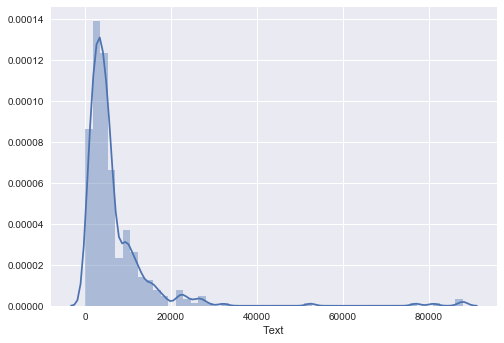

In [83]:
sns.distplot(tt_test_valids['Text'].str.len())

In [ ]:
###########################
###########################
#RE test here
#
###########################

In [87]:
tt_train['Text'].str.len().sort_values(ascending = True)[:20]
#[50:100]

1407      5
2755      5
1277      5
1109      5
1639      5
1613    338
108     364
2929    398
1380    419
3106    432
3107    432
670     446
1287    462
2971    471
926     471
899     471
3052    471
909     471
916     471
201     478
Name: Text, dtype: int64

In [88]:
lens = pd.DataFrame(tt_test['Text'].str.len())
#lens.head()
#lens.idxmax()
lens.median()
#lens.quantile(q=0.75)
#If needed, just take the first 5000 words in each entry

Text    4824.5
dtype: float64

In [89]:
train_corpus = tt_train['Text'].values.tolist()
test_corpus = tt_test['Text'].values.tolist()
stage2_corpus = tt_stage2['Text'].values.tolist()
train_test_stage2_corpus = train_corpus + test_corpus + stage2_corpus

test_val_corpus = tt_test_valids['Text'].values.tolist()

In [90]:
train_corpus[:2]

["Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK

In [91]:
test_corpus[:2]

['2. This mutation resulted in a myeloproliferative phenotype, including erythrocytosis, in a murine model of retroviral bone marrow transplantation.  CONCLUSIONS  JAK2 exon 12 mutations define a distinctive myeloproliferative syndrome that affects patients who currently receive a diagnosis of polycythemia vera or idiopathic erythrocytosis.  The myeloproliferative disorders comprise a spectrum of chronic hematologic diseases that are likely to arise from a mutant multipotent hematopoietic stem cell.1,2 The V617F somatic mutation in the Janus kinase (JAK) 2 gene (JAK2), which causes the substitution of phenylalanine for valine at position 617, has recently been found in the majority of patients with polycythemia vera and in many with essential thrombocythemia or idiopathic myelofibrosis.3-7 This gene encodes a cytoplasmic tyrosine kinase. The mutation, which occurs in the JAK homology 2 (JH2) negative regulatory domain, increases JAK2 kinase activity and causes cytokine-independent grow

In [92]:
stage2_corpus[:2]

[' CHEK2 (Cell-cycle-checkpoint kinase 2, also known as CHK2) encodes a multifunctional kinase that is activated mainly by the ataxia-telangiectasia mutated (ATM) protein in response to DNA double-strand breaks . Activated CHEK2 in turn phosphorylates several critical cell-cycle proteins, including p53, Cdc25 and BRCA1, which trigger cell-cycle arrest, apoptosis, and the activation of DNA repair .  Numerous studies have demonstrated that CHEK2 is a moderate breast cancer susceptibility gene . CHEK2 1100delC, a truncating mutation that abrogates the kinase activity of the protein, confers an approximately 2-fold increase in breast cancer risk [8,13-15]. However, the prevalence of CHEK2 1100delC mutation varies widely among ethnic groups [8,11,16-19]. The mutation is mostly found in the Dutch population , and it is absent or very rare in other populations . We previously screened Chinese women (1027 breast cancer cases and healthy controls) for CHEK2 1100delC and failed to find this muta

In [93]:
train_test_stage2_corpus[:2]

["Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK

In [94]:
#IN GENERAL, DONT MAKE OWN VOCAB
#DOWNLAOD GLOVE OR WORD2VEC
SEQ_LEN = 2000
MAX_WORDS = 5000
tokenizer = Tokenizer(num_words=MAX_WORDS)

#or take all words as tokens
#tokenizermax_words = Tokenizer()

In [95]:
#probably have to use a loop for this
tokenizer.fit_on_texts(train_test_stage2_corpus)
WORD_INDEX = tokenizer.word_index
print(WORD_INDEX)

{'gai': 36761, 'cd120a': 75132, 'localizer': 23540, 'localizes': 4938, 'vihinen': 38181, 'gag': 4627, 'circuitry': 16480, 'hanging': 18998, 'localized': 1512, 'dasatinb': 60215, 'caner': 39897, 'sprague': 36861, "'autoacetylation": 59748, 'q146k': 62157, 'turrax': 41634, 'themutation': 50198, 'gaa': 5111, 'amplification2': 38108, '9715s': 35925, '36ggt': 55436, 'sigfp': 52671, 'rsavdtnlhnlqdyve': 40517, 'osteoblastic': 12080, 'pigment': 12622, 'cfc': 1426, 'mdb4': 51726, 'bringing': 15540, 'antiavidin': 75484, 'ros1s1986y': 23048, 'guertin': 23428, 'eappendix': 37736, 'multiorgan': 27505, 'aucinf': 60723, 'intracelluar': 51121, 'woods': 32522, 'amplifications': 1904, 'ros1s1986f': 26245, '598c': 81632, 'figure4d4d': 73475, '0059': 49459, 'pa317': 21144, 'rras2': 18484, 'sh1n': 59606, '0056': 58317, '0055': 73402, '270': 5521, '271': 12452, '272': 7783, '273': 5911, '274': 13215, '275': 7392, '276': 10879, '277': 7520, '278': 12341, '279': 8793, 'lossoffunction': 31764, 'sbccd': 22133, 

In [96]:
import operator
sorted(WORD_INDEX.items(), key=operator.itemgetter(1))
#sorted(WORD_INDEX.items(), key=operator.itemgetter(1), reverse=True)

[('the', 1),
 ('of', 2),
 ('and', 3),
 ('in', 4),
 ('to', 5),
 ('a', 6),
 ('with', 7),
 ('that', 8),
 ('for', 9),
 ('is', 10),
 ('mutations', 11),
 ('by', 12),
 ('were', 13),
 ('was', 14),
 ('as', 15),
 ('are', 16),
 ('or', 17),
 ('cells', 18),
 ('1', 19),
 ('cell', 20),
 ('cancer', 21),
 ('from', 22),
 ('this', 23),
 ('we', 24),
 ('at', 25),
 ('have', 26),
 ('these', 27),
 ('2', 28),
 ('on', 29),
 ('an', 30),
 ('been', 31),
 ('protein', 32),
 ('mutation', 33),
 ('gene', 34),
 ('be', 35),
 ('patients', 36),
 ('which', 37),
 ('3', 38),
 ('5', 39),
 ('not', 40),
 ('tumor', 41),
 ('expression', 42),
 ('kinase', 43),
 ('dna', 44),
 ('c', 45),
 ('domain', 46),
 ('has', 47),
 ('using', 48),
 ('also', 49),
 ('activity', 50),
 ('genes', 51),
 ('tumors', 52),
 ('et', 53),
 ('0', 54),
 ('all', 55),
 ('al', 56),
 ('4', 57),
 ('binding', 58),
 ('type', 59),
 ('analysis', 60),
 ('mutant', 61),
 ('activation', 62),
 ('human', 63),
 ('10', 64),
 ('proteins', 65),
 ('it', 66),
 ('two', 67),
 ('other',

In [97]:
print('Found %s unique tokens.' % len(WORD_INDEX))

Found 90276 unique tokens.


In [98]:
train_seq = tokenizer.texts_to_sequences(train_corpus)
test_seq = tokenizer.texts_to_sequences(test_corpus)
test_val_seq = tokenizer.texts_to_sequences(test_val_corpus)
stage2_seq = tokenizer.texts_to_sequences(stage2_corpus)

In [99]:
test_val_seq[0] #1277:1279

[2920,
 65,
 39,
 3943,
 29,
 44,
 3,
 754,
 208,
 795,
 4,
 424,
 646,
 881,
 11,
 2,
 1424,
 16,
 426,
 166,
 4,
 405,
 323,
 24,
 239,
 1,
 974,
 257,
 2,
 63,
 1424,
 598,
 5,
 3374,
 44,
 25,
 28,
 3483,
 1206,
 1,
 257,
 903,
 8,
 67,
 1696,
 1,
 4219,
 1258,
 3,
 215,
 610,
 5,
 356,
 6,
 416,
 46,
 1,
 4219,
 1258,
 46,
 4331,
 1,
 44,
 718,
 1,
 516,
 1424,
 818,
 4058,
 2238,
 3,
 903,
 601,
 4415,
 9,
 3943,
 4,
 6,
 2238,
 939,
 3943,
 10,
 3222,
 126,
 1,
 416,
 4447,
 7,
 1,
 3328,
 362,
 5,
 416,
 4985,
 318,
 9,
 519,
 1,
 3328,
 362,
 10,
 40,
 293,
 4,
 1424,
 44,
 2372,
 711,
 8,
 1,
 416,
 4447,
 1863,
 1424,
 5,
 3943,
 4960,
 9,
 245,
 3759,
 11,
 2,
 4985,
 318,
 44,
 1952,
 3,
 1696,
 209,
 16,
 426,
 166,
 4,
 63,
 108,
 142,
 87,
 386,
 6,
 383,
 743,
 9,
 706,
 1,
 281,
 2,
 2920,
 268,
 3943,
 3759,
 1956,
 672,
 9,
 89,
 89,
 1802,
 572,
 44,
 662,
 25,
 39,
 651,
 2,
 3943,
 10,
 30,
 208,
 2044,
 37,
 1533,
 900,
 34,
 42,
 190,
 3,
 68,
 881,
 2,
 1207,


In [100]:
def limit_words(x):
    for i in range(len(x)):
        x[i] = x[i][:SEQ_LEN]
    return (x)

In [101]:
train_seq_limit = limit_words(train_seq)
test_seq_limit = limit_words(test_seq)
test_val_seq_limit = limit_words(test_val_seq)
stage2_seq_limit = limit_words(stage2_seq)

In [102]:
len(test_seq[1278])
len(test_seq_limit[1278])
#test_seq_limit[1278]

116

In [103]:
train_data = pad_sequences(train_seq_limit, maxlen=SEQ_LEN, value=0)

In [104]:
test_data = pad_sequences(test_seq_limit, maxlen=SEQ_LEN, value=0)

In [105]:
test_val_data = pad_sequences(test_val_seq, maxlen=SEQ_LEN, value=0)

In [106]:
stage2_data = pad_sequences(stage2_seq_limit, maxlen=SEQ_LEN, value=0)

In [107]:
stage2_data[0]

array([   0,    0,    0, ..., 2130,  668,  205])

In [108]:
train_data.shape

(3321L, 2000L)

In [109]:
test_data.shape

(5300L, 2000L)

In [110]:
test_val_data.shape

(368L, 2000L)

In [111]:
stage2_data.shape

(986L, 2000L)

In [112]:
EMBEDDING_DIM = 100

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [113]:
embeddings_index

{'biennials': array([-0.049107  ,  1.08360004, -0.96898001, -0.1956    ,  0.50419998,
         0.20568   ,  0.11316   , -0.27911001,  0.25615999, -0.23221999,
        -0.011899  , -0.84183002, -0.0075647 , -0.19212   , -0.64504999,
         0.14263999, -0.0040923 ,  1.05639994,  0.51504999, -0.30537   ,
        -0.18885   ,  0.22644   ,  0.18100999,  0.74606001,  0.88639998,
         0.18043999, -0.067711  , -0.0088145 , -0.45453   , -0.33256   ,
        -0.38935   , -0.60575002, -0.13333   ,  0.10477   ,  0.016106  ,
         0.73909998,  0.55728   , -0.31496   , -0.72784001, -0.32056999,
         0.36873999,  0.59378999, -0.23812   , -0.17137   ,  0.16075   ,
         0.30294999,  0.50081998, -0.47354999, -0.082908  ,  0.25314   ,
         0.27790001, -0.35703   , -0.27447   , -0.67198998, -0.072644  ,
         1.19550002,  0.17128   , -0.015494  , -0.41771999,  0.25037   ,
        -0.35641   ,  1.01950002, -0.41484001,  0.36528999, -0.43866   ,
        -0.51964998, -0.18813001, -0.2

In [114]:
embedding_matrix = np.zeros((len(WORD_INDEX) + 1, EMBEDDING_DIM))
for word, i in WORD_INDEX.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [115]:
embedding_matrix[2:4]

array([[-0.1529    , -0.24279   ,  0.89837003,  0.16996001,  0.53516001,
         0.48784   , -0.58825999, -0.17982   , -1.35810006,  0.42541   ,
         0.15377   ,  0.24214999,  0.13474   ,  0.41192999,  0.67043   ,
        -0.56418002,  0.42985001, -0.012183  , -0.11677   ,  0.31781   ,
         0.054177  , -0.054273  ,  0.35516   , -0.30241001,  0.31434   ,
        -0.33846   ,  0.71714997, -0.26855001, -0.15837   , -0.47466999,
         0.051581  , -0.33252001,  0.15003   , -0.12989999, -0.54617   ,
        -0.37843001,  0.64261001,  0.82187003, -0.080006  ,  0.078479  ,
        -0.96976   , -0.57740998,  0.56490999, -0.39873001, -0.057099  ,
         0.19743   ,  0.065706  , -0.48091999, -0.20125   , -0.40834001,
         0.39456001, -0.02642   , -0.11838   ,  1.01199996, -0.53171003,
        -2.74740005, -0.042981  , -0.74848998,  1.75740004,  0.59085   ,
         0.04885   ,  0.78267002,  0.38497001,  0.42096999,  0.67882001,
         0.10337   ,  0.63279998, -0.026595  ,  0.5

In [ ]:
#########################################3
#######################################333
########################################3
#######################################

#Need to combine training_full and test full genes and vars before one hot encoding - for mlp

In [ ]:
#Come back to this if needed
#pre_MLP_CNN_variants = pd.concat([train_no_text, pd.DataFrame(train_data), pd.DataFrame(train_labels)], axis=1)

In [116]:
searchfor = ['ID', 'Gene', 'Variation']
searchfor

['ID', 'Gene', 'Variation']

In [117]:
train_no_text = training_full.loc[:,training_full.columns.str.contains('|'.join(searchfor))]
train_no_text.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
train_no_text.shape

(3321, 10266)

In [119]:
train_labels = training_full.loc[:,training_full.columns.str.contains('Class')]
train_labels.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [120]:
train_MLP_CNN = pd.concat([train_no_text, pd.DataFrame(train_data), train_labels], axis=1)
train_MLP_CNN.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,1999,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,0,0,0,0,0,0,0,0,0,0,...,265,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,0,0,0,0,0,0,...,21,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0,0,0,0,0,0,0,0,...,21,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,0,0,0,0,0,0,0,0,...,1452,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,0,0,0,0,0,0,0,0,...,11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [121]:
#x_split = .iloc[:,train_no_text.shape[1]:]
#x_split = train_MLP_CNN.drop(['Class'], axis=1)
x_split = train_MLP_CNN.iloc[:,:(train_MLP_CNN.shape[1]-9)]
y_split = train_MLP_CNN.iloc[:,(train_MLP_CNN.shape[1]-9):]
x_split.head()
#y_split.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,0,0,0,0,0,0,0,0,0,...,4828,18,3108,7,1981,1563,17,198,4422,265
1,1,0,0,0,0,0,0,0,0,0,...,1,218,287,2,375,3,93,4,179,21
2,2,0,0,0,0,0,0,0,0,0,...,1,218,287,2,375,3,93,4,179,21
3,3,0,0,0,0,0,0,0,0,0,...,3501,1853,3299,3,369,2439,20,76,1415,1452
4,4,0,0,0,0,0,0,0,0,0,...,679,2,1,4026,301,5,1520,1914,2,11


In [122]:
test_val_no_text = test_validations.loc[:,test_validations.columns.str.contains('|'.join(searchfor))]
test_val_no_text.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,55,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,64,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [123]:
test_val_no_text.shape

(368, 10266)

In [124]:
test_vals_labels = test_validations.iloc[:,(test_validations.shape[1]-9):]
test_vals_labels.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [125]:
val_MLP_CNN = pd.concat([test_val_no_text, pd.DataFrame(test_val_data), test_vals_labels], axis=1)
val_MLP_CNN.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,1999,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,12,0,0,0,0,0,0,0,0,0,...,3759,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19,0,0,0,0,0,0,0,0,0,...,1020,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21,0,0,0,0,0,0,0,0,0,...,23,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55,0,0,0,0,0,0,0,0,0,...,1066,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,64,0,0,0,0,0,0,0,0,0,...,148,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [126]:
val_MLP_CNN.shape

(368, 12275)

In [127]:
x_validation = val_MLP_CNN.iloc[:,:(val_MLP_CNN.shape[1]-9)]
y_validation = val_MLP_CNN.iloc[:,(val_MLP_CNN.shape[1]-9):]
x_validation.head()


,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,12,0,0,0,0,0,0,0,0,0,...,1591,9,706,1,281,2,2920,268,44,3759
1,19,0,0,0,0,0,0,0,0,0,...,15,2790,4,2955,21,156,5,503,539,1020
2,21,0,0,0,0,0,0,0,0,0,...,73,1613,29,1,1773,18,4,27,36,23
3,55,0,0,0,0,0,0,0,0,0,...,3642,2730,162,5,832,1410,3,1444,2,1066
4,64,0,0,0,0,0,0,0,0,0,...,1898,865,34,252,252,13,1372,15,115,148


In [169]:
y_validation.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [128]:
test_full_no_text = test_full.loc[:,test_full.columns.str.contains('|'.join(searchfor))]
test_full_no_text.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
test_full_no_text.shape

(5300, 10266)

In [130]:
test_MLP_CNN = pd.concat([test_full_no_text, pd.DataFrame(test_data)], axis=1)
test_MLP_CNN.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,0,0,0,0,0,0,0,0,0,...,1329,1616,574,1844,194,3,3425,684,16,2268
1,1,0,0,0,0,0,0,0,0,0,...,2392,543,149,246,939,10,618,45,375,143
2,2,0,0,0,0,0,0,0,0,0,...,37,14,49,71,7,1,2,4,21,36
3,3,0,0,0,0,0,0,0,0,0,...,3445,1007,182,29,1,190,1715,2,1,41
4,4,0,0,0,0,0,0,0,0,0,...,109,138,19,138,19,2314,899,387,9,1967


In [131]:
test_MLP_CNN.shape

(5300, 12266)

In [132]:
stage2_no_text = stage2_full.loc[:,stage2_full.columns.str.contains('|'.join(searchfor))]
stage2_no_text.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
stage2_no_text.head()
stage2_no_text.shape[1]
stage2_no_text.shape

(986, 10266)

In [134]:
stage2_MLP_CNN = pd.concat([stage2_no_text, pd.DataFrame(stage2_data)], axis=1)
val_MLP_CNN.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,1999,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,12,0,0,0,0,0,0,0,0,0,...,3759,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19,0,0,0,0,0,0,0,0,0,...,1020,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21,0,0,0,0,0,0,0,0,0,...,23,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55,0,0,0,0,0,0,0,0,0,...,1066,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,64,0,0,0,0,0,0,0,0,0,...,148,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [135]:
X = pd.concat([x_split, x_validation])
X.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,0,0,0,0,0,0,0,0,0,...,4828,18,3108,7,1981,1563,17,198,4422,265
1,1,0,0,0,0,0,0,0,0,0,...,1,218,287,2,375,3,93,4,179,21
2,2,0,0,0,0,0,0,0,0,0,...,1,218,287,2,375,3,93,4,179,21
3,3,0,0,0,0,0,0,0,0,0,...,3501,1853,3299,3,369,2439,20,76,1415,1452
4,4,0,0,0,0,0,0,0,0,0,...,679,2,1,4026,301,5,1520,1914,2,11


In [136]:
y = pd.concat([y_split, y_validation])
y.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [224]:
x_train, x_val, y_train, y_val = train_test_split(X, y, stratify=y, train_size=0.90, random_state=0)

In [225]:
#x_train = pd.concat([x_train, x_val])

In [226]:
x_train.shape

(3320, 12266)

In [227]:
#x_val = pd.concat([x_val, x_validation])

In [228]:
x_val.shape

(369, 12266)

In [229]:
#y_train = pd.concat([y_train, y_val])

In [230]:
cols = y_train.columns.values.tolist()
cols
y_train[cols] = y_train[cols].applymap(np.int32)
#y_train[cols] = y_train[cols].astype(int)
y_train = y_train.values
y_train

array([[0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int64)

In [231]:
y_train.dtype
#y_train.shape

dtype('int64')

In [232]:
y_val.isnull().values.any()

False

In [233]:
#y_val = pd.concat([y_val, y_validation])

In [234]:
val_cols = y_val.columns.values.tolist()
val_cols

y_val[val_cols] = y_val[val_cols].applymap(np.int32)
#y_val[val_cols] = y_val[val_cols].astype(int)
y_val = y_val.values
y_val

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ..., 
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [235]:
y_val.dtype

dtype('int64')

In [236]:
y_val.shape

(369L, 9L)

In [237]:
train_no_text.shape

(3321, 10266)

In [238]:
#x_train.iloc[:,train_no_text.shape[1]:].head()
x_train.iloc[:,:train_no_text.shape[1]].head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
3125,3125,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
504,504,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1445,1445,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1872,1872,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1502,1502,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [240]:
x_train.iloc[:,train_no_text.shape[1]:].head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
3125,0,0,0,0,0,0,0,0,0,0,...,113,1437,1133,833,2355,731,1471,833,551,159
504,0,0,0,0,0,0,0,0,0,0,...,2,69,3,3343,89,116,1159,572,1956,572
1445,0,0,0,0,0,0,0,0,0,0,...,3642,2730,162,5,832,1410,3,1444,2,1066
1872,0,0,0,0,0,0,0,0,0,0,...,15,2790,4,2955,21,156,5,503,539,1020
1502,0,0,0,0,0,0,0,0,0,0,...,233,432,17,33,549,832,30,1073,384,4


In [241]:
x_train_cnn = x_train.iloc[:,train_no_text.shape[1]:]
x_train_cnn = x_train_cnn.values

x_val_cnn = x_val.iloc[:,train_no_text.shape[1]:]
x_val_cnn = x_val_cnn.values

In [242]:
x_train_cnn

array([[   0,    0,    0, ...,  833,  551,  159],
       [   0,    0,    0, ...,  572, 1956,  572],
       [   0,    0,    0, ..., 1444,    2, 1066],
       ..., 
       [   0,    0,    0, ...,    3,  163,  487],
       [   0,    0,    0, ...,    2,  352,  724],
       [   0,    0,    0, ...,   38,   43,   76]])

In [243]:
x_val_cnn

array([[   0,    0,    0, ...,    4, 3188, 3270],
       [   0,    0,    0, ...,   12, 1837,  140],
       [   0,    0,    0, ..., 2171, 2045,  144],
       ..., 
       [   0,    0,    0, ...,  148,  115,   38],
       [   0,    0,    0, ..., 3258,   10,  618],
       [   0,    0,    0, ...,   31,  148,   70]])

In [245]:
x_val.iloc[:,:train_no_text.shape[1]].head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
149,2281,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1107,1107,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
745,745,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,112,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3096,3096,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [246]:
x_train_fc = x_train.iloc[:,:train_no_text.shape[1]]
x_train_fc = x_train_fc.drop(['ID'], axis=1)
x_train_fc = x_train_fc.values

x_val_fc = x_val.iloc[:,:train_no_text.shape[1]]
x_val_fc = x_val_fc.drop(['ID'], axis=1)
x_val_fc = x_val_fc.values

In [247]:
x_train_fc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [248]:
x_val_fc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [249]:
x_val_fc.shape

(369L, 10265L)

In [250]:
test_MLP_CNN.iloc[:,test_full_no_text.shape[1]:].head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,0,0,0,0,0,0,0,0,0,...,1329,1616,574,1844,194,3,3425,684,16,2268
1,0,0,0,0,0,0,0,0,0,0,...,2392,543,149,246,939,10,618,45,375,143
2,0,0,0,0,0,0,0,0,0,0,...,37,14,49,71,7,1,2,4,21,36
3,0,0,0,0,0,0,0,0,0,0,...,3445,1007,182,29,1,190,1715,2,1,41
4,0,0,0,0,0,0,0,0,0,0,...,109,138,19,138,19,2314,899,387,9,1967


In [251]:
test_cnn = test_MLP_CNN.iloc[:,test_full_no_text.shape[1]:]
test_cnn = test_cnn.values

In [252]:
test_cnn

array([[   0,    0,    0, ...,  684,   16, 2268],
       [   0,    0,    0, ...,   45,  375,  143],
       [   0,    0,    0, ...,    4,   21,   36],
       ..., 
       [  55,   83,    2, ...,  109,  250,   88],
       [   0,    0,    0, ...,  987,   16,  114],
       [   0,    0,    0, ...,    9,  120, 1932]])

In [253]:
test_fc = test_MLP_CNN.iloc[:,:test_full_no_text.shape[1]]
test_fc = test_fc.drop(['ID'], axis=1)
test_fc = test_fc.values

In [254]:
stage2_MLP_CNN.iloc[:,stage2_no_text.shape[1]:].head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,0,0,0,0,0,0,0,0,0,...,451,112,1612,33,487,3,3332,2130,668,205
1,0,0,0,0,0,0,0,0,0,0,...,3,283,5,3351,81,103,885,1833,205,81
2,0,0,0,0,0,0,0,0,0,0,...,37,14,49,71,7,1,2,4,21,36
3,0,0,0,0,0,0,0,0,0,0,...,411,3,536,281,8,191,270,568,34,42
4,0,0,0,0,0,0,0,0,0,0,...,2774,3,1041,1898,10,644,4,1,1762,488


In [255]:
stage2_cnn = stage2_MLP_CNN.iloc[:,stage2_no_text.shape[1]:]
stage2_cnn = stage2_cnn.values

In [256]:
stage2_cnn

array([[   0,    0,    0, ..., 2130,  668,  205],
       [   0,    0,    0, ..., 1833,  205,   81],
       [   0,    0,    0, ...,    4,   21,   36],
       ..., 
       [   0,    0,    0, ...,   92,  767, 1161],
       [   0,    0,    0, ...,   95, 2269, 2308],
       [   0,    0,    0, ...,    4, 2267,  217]])

In [257]:
stage2_MLP_CNN.iloc[:,:stage2_no_text.shape[1]].head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [258]:
stage2_fc = stage2_MLP_CNN.iloc[:,:stage2_no_text.shape[1]]
stage2_fc = stage2_fc.drop(['ID'], axis=1)
stage2_fc = stage2_fc.values

In [259]:
stage2_fc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [260]:
len(WORD_INDEX)

90276

In [261]:
SEQ_LEN

2000

In [262]:
embedding_matrix.shape

(90277L, 100L)

In [263]:
#Glove trained embedding
embedding_layer = Embedding(input_dim=len(WORD_INDEX) + 1,
                            output_dim=EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=SEQ_LEN,
                            trainable=False)

In [269]:
sequence_input = Input(shape=(SEQ_LEN,), dtype='int32', name='main_input')
embedded_sequences = embedding_layer(sequence_input)

conv = Conv1D(64, 3, activation='relu')(embedded_sequences)
conv = MaxPooling1D(5)(conv) #3 #add dropout after this
conv = BatchNormalization()(conv)
conv = Conv1D(128, 3, activation='relu')(conv)
conv = MaxPooling1D(5)(conv)
conv = Conv1D(256, 3, activation='relu')(conv) #remove
conv = MaxPooling1D(35)(conv) #remove
conv = Dropout(0.7)(conv)
conv = Flatten()(conv)
conv = BatchNormalization()(conv)
conv = Dropout(0.7)(conv)
conv = Dense(256, activation='relu')(conv)
conv = BatchNormalization()(conv)
conv = Dropout(0.7)(conv)
conv_out = Dense(9, activation='softmax')(conv)

#x = keras.layers.concatenate([conv_out, auxiliary_input])

#cnn = Model(inputs=sequence_input, outputs=conv_out)
#cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 2000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2000, 100)         9027700   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1998, 64)          19264     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 399, 64)           0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 399, 64)           256       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 397, 128)          24704     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 79, 128)           0         
__________

In [270]:
FC_SEQ_LEN = int(x_train_fc.shape[1])
FC_SEQ_LEN

10265

In [271]:
auxiliary_input = Input(shape=(FC_SEQ_LEN,), name='aux_input')

x = keras.layers.concatenate([conv_out, auxiliary_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(9, activation='softmax', name='main_output')(x)

In [272]:
model = Model(inputs=[sequence_input, auxiliary_input], outputs=[main_output])

In [ ]:
#lr=0.001

In [273]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              loss_weights={'main_output': 1.0},
              metrics=['acc'])

In [274]:
BATCH_SZ = 128

In [ ]:
#train initial model with 5 epochs
#train model second time (with test predictions) with 4 epochs
####################

model.fit({'main_input': x_train_cnn, 'aux_input': x_train_fc}, {'main_output': y_train}, 
          validation_data=({'main_input': x_val_cnn, 'aux_input': x_val_fc}, {'main_output': y_val}),
          epochs=4, batch_size=BATCH_SZ)

Train on 3320 samples, validate on 369 samples
Epoch 1/4
2944/3320 [=========================>....] - ETA: 13s - loss: 0.5682 - acc: 0.8434

In [ ]:
test_preds = model.predict({'main_input': test_cnn, 'aux_input': test_fc}, batch_size=BATCH_SZ)

In [ ]:
test_preds

In [ ]:
test_labels = np.argmax(test_preds, axis=1)
test_labels = pd.DataFrame(test_labels, columns = ['Class'])
test_labels['Class'].unique()

In [ ]:
test_labels = test_labels.append(pd.DataFrame([2,7,8], columns = ['Class']))
test_labels.head()

In [ ]:
test_labels.tail()

In [ ]:
test_labels_one_hot = keras.utils.to_categorical(test_labels['Class'])
test_labels_one_hot = pd.DataFrame(test_labels_one_hot)
test_labels_one_hot.tail()

In [ ]:
test_labels_one_hot = test_labels_one_hot.drop(test_labels_one_hot.index[[5300,5301,5302]])
test_labels_one_hot.tail()

In [ ]:
test_labels_arr = np.array(test_labels_one_hot.astype(int))
test_labels_arr

In [ ]:
sns.distplot(test_labels['Class'])

In [ ]:
test_labels_arr[3]

In [ ]:
x_train_cnn = np.vstack((x_train_cnn,test_cnn))

In [ ]:
x_train_fc = np.vstack((x_train_fc,test_fc))

In [ ]:
y_train = np.vstack((y_train, test_labels_arr))

In [ ]:
stage2_preds = model.predict({'main_input': stage2_cnn, 'aux_input': stage2_fc}, batch_size=BATCH_SZ)

In [ ]:
csv_5epochs = pd.DataFrame(stage2_preds_5epochs)
csv_5epochs.to_csv('stage2_preds_5epochs.csv', sep=',')
csv_5epochs.head()

In [ ]:
stage2_5eps_labels = np.argmax(np.asarray(csv_5epochs), axis=1)
stage2_5eps_labels = pd.DataFrame(stage2_5eps_labels, columns = ['Class'])
stage2_5eps_labels['Class'] = stage2_5eps_labels['Class'].astype(str)
#test_labels['Class'].unique()
stage2_5eps_labels = pd.get_dummies(stage2_5eps_labels)
stage2_5eps_labels.head()

In [ ]:
stage2_5eps_labels.to_csv('stage2_5eps_labels.csv', sep=',')

In [ ]:
csv_4epochs = pd.DataFrame(stage2_preds_4epochs)
csv_4epochs.to_csv('stage2_preds_4epochs.csv', sep=',')
csv_4epochs.head()

In [ ]:
stage2_4ep_labels = np.argmax(np.asarray(csv_4epochs), axis=1)
stage2_4ep_labels = pd.DataFrame(stage2_4ep_labels, columns = ['Class'])
stage2_4ep_labels['Class'] = stage2_4ep_labels['Class'].astype(str)
#test_labels['Class'].unique()
stage2_4ep_labels = pd.get_dummies(stage2_4ep_labels)
stage2_4ep_labels.head()